In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Dense, Bidirectional, Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Dropout, Activation, Flatten, Input
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical, pad_sequences
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import gensim.downloader as api
import pytreebank

from keras.layers import CuDNNLSTM, SpatialDropout1D, Conv1D, Layer
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from keras import backend as K
from keras import initializers


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pytreebank.load_sst("data/stanfordSentimentTreebank/trees")


for item in data['train']:
    print(item.to_labeled_lines()[0][0],item.to_labeled_lines()[0][1])
    break

3 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [3]:
out_path = os.path.join("data/stanfordSentimentTreebank/working/sst_{}.txt")# new file format
for cat in ['train','test','dev']:
    with open(out_path.format(cat),"w") as file:
        for item in data[cat]:
            file.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] +1,
                item.to_labeled_lines()[0][1]
            ))
    
    print("done with {}".format(file))

done with <_io.TextIOWrapper name='data/stanfordSentimentTreebank/working/sst_train.txt' mode='w' encoding='UTF-8'>
done with <_io.TextIOWrapper name='data/stanfordSentimentTreebank/working/sst_test.txt' mode='w' encoding='UTF-8'>
done with <_io.TextIOWrapper name='data/stanfordSentimentTreebank/working/sst_dev.txt' mode='w' encoding='UTF-8'>


In [4]:
df_train = pd.read_csv('data/stanfordSentimentTreebank/working/sst_train.txt', sep='\t',header=None,names=['sentiment','content'])
df_train['sentiment'] = df_train['sentiment'].str.replace("__label__","")
df_train['sentiment'] = df_train['sentiment'].astype(int)#.astype("category")
df_train['sentiment'] = df_train['sentiment'] - 1
df_train

df_val = pd.read_csv('data/stanfordSentimentTreebank/working/sst_test.txt', sep='\t',header=None,names=['sentiment','content'])
df_val['sentiment'] = df_val['sentiment'].str.replace("__label__","")
df_val['sentiment'] = df_val['sentiment'].astype(int)#.astype("category")
df_val['sentiment'] = df_val['sentiment'] - 1
df_val

,sentiment,content
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...
...,...,...
2205,3,An imaginative comedy/thriller .
2206,4,"( A ) rare , beautiful film ."
2207,4,( An ) hilarious romantic comedy .
2208,3,Never ( sinks ) into exploitation .


In [5]:
df_train.reset_index(drop=True, inplace=True)
df_train.head(5)
df_val.reset_index(drop=True, inplace=True)
df_val.head(5)


,sentiment,content
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...


In [6]:
df_train['sentiment'].unique()

array([3, 4, 2, 1, 0])

In [8]:
import torch
import tqdm
import text_hammer as th
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def pre_pro(df):
    # These are series of preprocessing
    df['content'] = df['content'].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df['content'] = df['content'].progress_apply(lambda x: th.remove_emails(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_html_tags(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_urls(x))

    df['content'] = df['content'].progress_apply(lambda x: th.remove_special_chars(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_accented_chars(x))
    df['content'] = df['content'].progress_apply(lambda x: th.make_base(x)) #ran -> run, 
    # df['content'] = df['content'].progress_apply(lambda x: th.spelling_correction(x).raw_sentences[0]) #seplling -> spelling
    print("Number of words with stopwords:",df['content'].str.split().str.len().sum())
    df["content"] = df['content'].progress_apply(lambda x: remove_stopwords(x))
    print("Number of words without stopwords:",df['content'].str.split().str.len().sum())

pre_pro(df_train)
pre_pro(df_val)




  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

Number of words with stopwords: 144703


  0%|          | 0/8544 [00:00<?, ?it/s]

Number of words without stopwords: 80579


  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

Number of words with stopwords: 37613


  0%|          | 0/2210 [00:00<?, ?it/s]

Number of words without stopwords: 20837


In [9]:
model_type = 'glove-wiki-gigaword-200'  # 25 100 200 word2vec 300 
wv_path = ['./data/train_data/train', './data/test_data/test']

w2vModel = api.load(model_type)

In [10]:
GLOVE_DIM = int(model_type.split('-')[-1])

In [29]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import tokenize
from bs4 import BeautifulSoup
from keras.preprocessing.text import text_to_word_sequence
import string
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])
#Preprocess both train and test separately. Remove punctuations and other unwanted characters
def replace_punct(st,punct):
  for i in punct:
    if i=="..":
      st = st.replace("..",'.')
    elif i=="--" or i == '-':
      st = st.replace(i,' ')
    else:
      st = st.replace(i,'')
  return st
punct = word_tokenize(string.punctuation) + ['``','...','..','\'s','--','-','n\'t','\'','(',')','[',']','{','}']
texts = preprocess(df_train['content']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x,punct))
test_text = preprocess(df_val['content']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x,punct))

MAX_SEQUENCE_LENGTH = 1000
MAX_SENT_LENGTH = 50
MAX_SENTS = 50
MAX_NB_WORDS = 50000

#Get all sentences for all news
articles = texts.map(lambda x: sent_tokenize(x))
test_articles = test_text.map(lambda x: sent_tokenize(x))

#Create 3D data with tokenizer word_index. Neglect words which are not in word_index
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1
                    
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Kiann\AppData\Local\Temp\ipykernel_27300\1943377199.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])


No. of 13871 unique tokens.


In [30]:
#Do the same for test data with the same tokenizer (fit on train data). Neglect words which are not in word_index
test_data = np.zeros((len(test_text), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(test_articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and word in tokenizer.word_index and tokenizer.word_index[word]<MAX_NB_WORDS:
                    test_data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [31]:
#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
labels = to_categorical(np.asarray(df_train['sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

np.random.seed(123)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

Shape of data tensor: (8544, 50, 50)
Shape of label tensor: (8544, 5)


In [32]:
wordLen = len(tokenizer.word_index)+1
wordLen

13872

In [33]:
## prepare a corresponding embedding matrix that used in a Keras Embedding layer. 
## It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

def embed(model, tokenizer):
    embed_size = GLOVE_DIM
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embed_size))

    hits = 0
    misses = 0

    # embedding matrix
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model.get_vector(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        except:
            misses += 1
        
            
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


embedding_matrix = embed (w2vModel, tokenizer)
embedding_matrix

Converted 12047 words (1824 misses)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18889   ,  0.19302   , -0.86576003, ...,  0.03805   ,
         0.23120999,  0.35679001],
       [ 0.33201   ,  0.30195001, -0.88213003, ...,  0.075378  ,
         0.39153999,  0.57608998],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31294   , -0.078469  ,  0.002469  , ...,  0.28196999,
        -0.26561999,  0.033496  ]])

In [34]:
# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self._trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]



In [39]:

embedding_layer = Embedding(wordLen, output_dim=GLOVE_DIM, input_length=MAX_SENT_LENGTH, weights=[embedding_matrix],trainable=False)
# Word
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_layer = Bidirectional(LSTM(100,dropout=.3))(embedded_sequences)
sentEncoder = Model(sentence_input, lstm_layer)

# Sentence
article_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
article_encoder = TimeDistributed(sentEncoder)(article_input)
lstm_layer_sent = Bidirectional(LSTM(100,dropout=.3))(article_encoder)
preds = Dense(len(df_train['sentiment'].unique()), activation='softmax')(lstm_layer_sent)
han_model = Model(article_input, preds)

han_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print(han_model.summary())
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
history = han_model.fit(xtrain, ytrain, epochs=200, batch_size=64, verbose=1,validation_data=(xval,yval),callbacks= [es])

print(han_model)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 50)]          0         
                                                                 
 time_distributed_4 (TimeDis  (None, 50, 200)          3015200   
 tributed)                                                       
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 3,257,005
Trainable params: 482,605
Non-trainable params: 2,774,400
_________________________________________________________________
None
Epoch 1/200
107/107 [=================

In [ ]:
import matplotlib.pyplot as plt
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.450


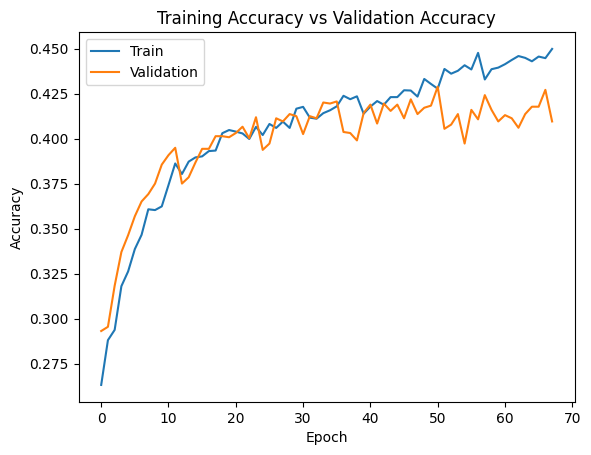

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

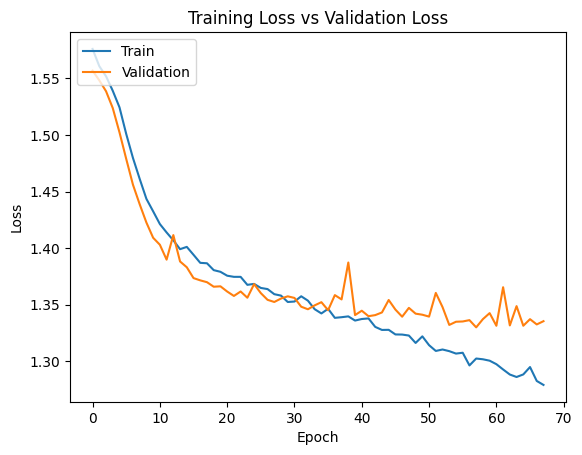

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()